In [399]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import pandas as pd

In [400]:
T = 0.01
s = ctl.TransferFunction.s

In [401]:
G = 97123.0366515921/(1.0*s**2 + 684974.722594433*s - 1324231.64800177)
C = (34.91*s**2 + 74.3964*s + 22.23)/(0.157*s**2 + 0.5644*s)

G_feedback = ctl.feedback(G*C, 1)
G_feedback

TransferFunction(array([3390565.20950708, 7225604.28394651, 2159045.10476489]), array([1.57000000e-01, 1.07541596e+05, 3.56926057e+06, 6.47820794e+06,
       2.15904510e+06]))

# TRANSFORMADA Z
Primeiro vamos aplicar a transformada $Z$ na planta com o método $zoh$ (que é adequado para a planta) e aplicar também uma outra transformada $z$ no controlador, com outro método de transformação mais adequado, para depois fechar a malha. As possíveis transformadas são:

- $zoh$ (zero-order hold on the inputs)
- $foh$ (linear interpolation of inputs)
- $tustin$ (bilinear approximation)
- $impulse$ (impulse-variant discretization)
- $matched$ (matched pole-zero method (for SISO systems only))

In [402]:
G_z = ctl.c2d(G, T, method='zoh')
G_z

TransferFunction(array([1.43148639e-03, 2.11040344e-07]), array([ 1.        , -1.01952059,  0.        ]), 0.01)

In [403]:
C_z = ctl.c2d(C, T, method='tustin')
C_z

TransferFunction(array([ 220.76145806, -436.85405326,  216.10650442]), array([ 1.        , -1.96468571,  0.96468571]), 0.01)

In [404]:
G_z_feedback = ctl.feedback(G_z*C_z, 1)
G_z_feedback

TransferFunction(array([ 3.16017023e-01, -6.25304042e-01,  3.09261326e-01,  4.56071910e-05]), array([ 1.00000000e+00, -2.66818928e+00,  2.34241921e+00, -6.74255622e-01,
        4.56071910e-05]), 0.01)

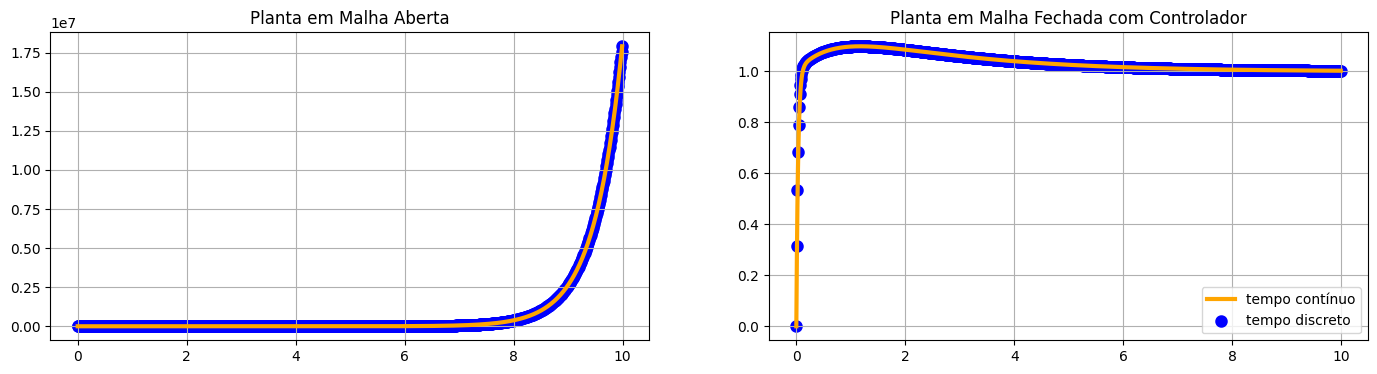

In [405]:
tData = np.arange(0, 10, T)
plt.figure(figsize=(17, 4))

plt.subplot(1, 2, 1)
time, continuous = ctl.step_response(G, T=tData)
time, digital    = ctl.step_response(G_z, T=tData)
plt.scatter(time, continuous, color='blue', linewidth=3, label='tempo discreto')
plt.plot(time, digital, color='orange', linewidth=3, label='tempo contínuo')
plt.title('Planta em Malha Aberta')
plt.grid()

plt.subplot(1, 2, 2)
time, continuous = ctl.step_response(G_feedback, T=tData)
time, digital    = ctl.step_response(G_z_feedback, T=tData)
plt.plot(time, continuous, color='orange', linewidth=3, label='tempo contínuo')
plt.scatter(time, digital, color='blue', linewidth=3, label='tempo discreto')
plt.title('Planta em Malha Fechada com Controlador')
plt.legend()
plt.grid()

# DIGITALIZANDO O SISTEMA
- Preparando as funções que permitem digitalizar a função de transferência em transformada $Z$
    - **getOutputString**: Passando os vetores dos coeficientes do numerador e denominador para uma string que é a própria função do sistema discretizada
    - **resetSystem**: reinicia as variáveis globais do sistema
    - **compute**: aplica a função digitalizada a partir dos estados anteriores

In [406]:
def getOutputString(G_z):
    num, den = ctl.tfdata(G_z)
    num = np.squeeze(num)
    den = np.squeeze(den)

    num = num/den[0]
    den = den/den[0]
    out = ''

    for i in range(0, len(num)):
        out += f'{num[i]}*X_n{i} + '

    for i in range(1, len(den)):
        out += f'+ {-1*den[i]}*Y_n{i}'

    return out.replace('X_n0', 'X_n').replace('+ +', '+').replace('+ -', '-')


def resetSystem():
    global Y_n1, Y_n2, Y_n3
    global X_n1, X_n2, X_n3
    Y_n1 = Y_n2 = Y_n3 = 0
    X_n1 = X_n2 = X_n3 = 0


def compute(X_n):
    global Y_n1, Y_n2, Y_n3
    global X_n1, X_n2, X_n3
    Y_n = eval(out)

    X_n3 = X_n2
    X_n2 = X_n1
    X_n1 = X_n

    Y_n3 = Y_n2
    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n


out = getOutputString(G_z)
out

'0.0014314863902318287*X_n + 2.1104034401642491e-07*X_n1 + 1.019520590720044*Y_n1-0.0*Y_n2'

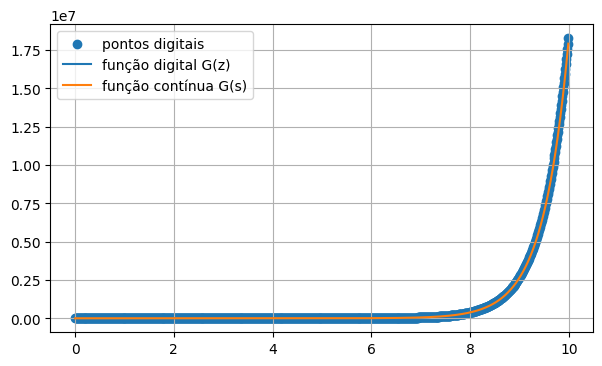

In [407]:
plt.figure(figsize=(7, 4))
time = np.arange(0, 10, T)

step = 1
resetSystem()

response = [compute(step) for i in time]
plt.scatter(time, response, label='pontos digitais')

time, response = ctl.step_response(G_z, T=time)
plt.plot(time, response, label='função digital G(z)')

time, response = ctl.step_response(G, T=time)
plt.plot(time, response, label='função contínua G(s)')
plt.grid()
plt.legend()

# DIGITALIZANDO O CONTROLADOR
- Comparando os dados contínuo e digital de forma gráfica através de um step

In [408]:
def control(input, setpoint):
    global Y_n1, Y_n2, Y_n3
    global X_n1, X_n2, X_n3

    X_n = setpoint - input
    Y_n = eval(out)

    X_n3 = X_n2
    X_n2 = X_n1
    X_n1 = X_n

    Y_n3 = Y_n2
    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n


out = getOutputString(C_z)
out

'220.76145805959126*X_n -436.8540532592508*X_n1 + 216.10650442367128*X_n2 + 1.9646857128555517*Y_n1-0.9646857128555517*Y_n2'

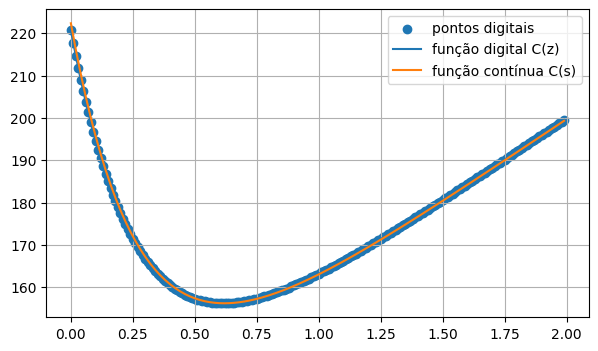

In [409]:
plt.figure(figsize=(7, 4))
time = np.arange(0, 2, T)

resetSystem()
response = [control(input=1, setpoint=2) for i in time]
plt.scatter(time, response, label='pontos digitais')

time, response = ctl.step_response(C_z, T=time)
plt.plot(time, response, label='função digital C(z)')

time, response = ctl.step_response(C, T=time)
plt.plot(time, response, label='função contínua C(s)')
plt.grid()
plt.legend()

# SIMULANDO SISTEMA
- O controlador envia um sinal $out$ para a planta, que gera um outro sinal, que é comparado com o setpoint e enviado de novo ao controlador

In [410]:
gout = getOutputString(G_z).replace('*X', '*GX').replace('*Y', '*GY')
cout = getOutputString(C_z).replace('*X', '*CX').replace('*Y', '*CY')

def compute(input):
    global GY_n1, GY_n2, GY_n3
    global GX_n1, GX_n2, GX_n3

    GX_n = input
    Y_n = eval(gout)

    GX_n3 = GX_n2
    GX_n2 = GX_n1
    GX_n1 = GX_n

    GY_n3 = GY_n2
    GY_n2 = GY_n1
    GY_n1 = Y_n
    return Y_n

def control(input, setpoint):
    global CY_n1, CY_n2, CY_n3
    global CX_n1, CX_n2, CX_n3
    global bounds

    CX_n = setpoint - input
    Y_n = eval(cout)

    if Y_n > bounds[1]: Y_n = bounds[1]
    if Y_n < bounds[0]: Y_n = bounds[0]

    CX_n3 = CX_n2
    CX_n2 = CX_n1
    CX_n1 = CX_n

    CY_n3 = CY_n2
    CY_n2 = CY_n1
    CY_n1 = Y_n
    return Y_n

print(gout)
print(cout)

0.0014314863902318287*GX_n + 2.1104034401642491e-07*GX_n1 + 1.019520590720044*GY_n1-0.0*GY_n2
220.76145805959126*CX_n -436.8540532592508*CX_n1 + 216.10650442367128*CX_n2 + 1.9646857128555517*CY_n1-0.9646857128555517*CY_n2


In [411]:
CY_n1 = CY_n2 = CY_n3 = 0
CX_n1 = CX_n2 = CX_n3 = 0
GY_n1 = GY_n2 = GY_n3 = 0
GX_n1 = GX_n2 = GX_n3 = 0
bounds = (-999999999, 999999999)

setpoint = 10
output   = 0
tData = []
yData = []
iData = []

for time in np.arange(0, 10, T):
    input  = compute(output)
    output = control(input, setpoint)

    tData.append(time)
    iData.append(input)
    yData.append(output)

print(yData[:10])

[2207.6145805959127, 1478.6990869626788, 977.5378486518007, 633.016689894939, 396.12268614867344, 233.18008636511092, 121.05098160657923, 43.83778080989791, -9.382444853059809, -46.11464363057161]


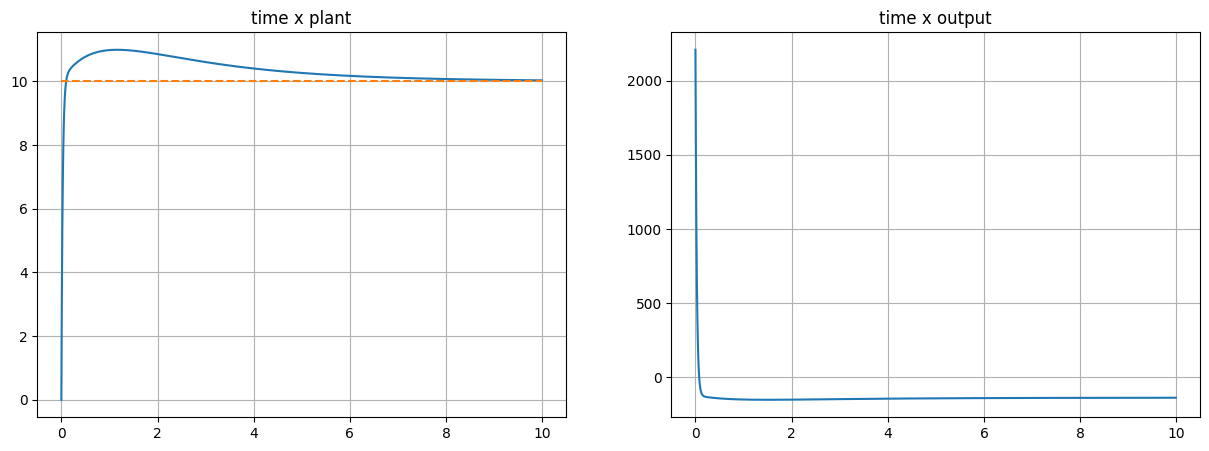

In [412]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(tData, iData)
plt.plot(tData, [setpoint for i in tData], '--')
plt.title('time x plant')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(tData, yData)
plt.title('time x output')
plt.grid()